In [1]:
!pip install bertopic==0.16.0 datasets==2.16.1 Arabic-Stopwords==0.4.3

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.1/154.1 kB 4.1 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 14.1 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 360.5/360.5 kB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.4/166.4 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 69.9 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.9.0
    Uninstalling fsspec-2024.9.0:
     

In [2]:
from datasets import load_dataset
import pandas as pd
import re
import random
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

def clean_text(text: str) -> str:

  if not isinstance(text, str):
    raise TypeError(f"Expected a string, but got {type(text)}")

  # remove urls
  text = re.sub(r"http\S+", " رابط ", text)

  # replace any digit with رقم
  tetx = re.sub(r"\d+", " رقم ", text)

  # set space before and after any punctuation
  text = re.sub(r"([^\w\s])", r" \1 ", text)

  # remove extra spaces
  text = re.sub(r"\s+", " ", text)

  words = word_tokenize(text)
  text = " ".join( [ w for w in words if len(w) > 1 ] )

  return text.lower().strip()

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [3]:
ar_dataset = load_dataset("saudinewsnet")

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1429: FutureWarning: The repository for saudinewsnet contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/saudinewsnet
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Generating train split:   0%|          | 0/31030 [00:00<?, ? examples/s]

In [4]:
ar_dataset["train"][0]

{'source': 'aawsat',
 'url': 'http://aawsat.com/home/article/410826/بريطانيا-أربعة-محاور-لاستراتيجية-جديدة-تتصدى-للتطرف-على-مدى-خمس-سنوات',
 'date_extracted': '2015-07-21 02:51:32',
 'title': 'بريطانيا: أربعة محاور لاستراتيجية جديدة تتصدى للتطرف على مدى خمس سنوات',
 'author': 'لندن: رنيم حنوش',
 'content': 'حدد رئيس الوزراء البريطاني ديفيد كاميرون، اليوم (الاثنين)، ملامح استراتيجية للتصدي للتطرف داخل بريطانيا؛ وهي مسألة اعتبرها كاميرون "صراع جيلنا"، متعهدا خلال خطابه في مدينة بيرمنغهام بالتصدي لهؤلاء الذين ينشرون التطرف بين الشبان المسلمين البريطانيين.\n\n ورسم كاميرون الاطار العام لاستراتيجية مكافحة التطرف التي المقرر ان تنشر كاملة في وقت لاحق هذا العام، والتي تسعى للتصدي لانتشار الأفكار المتطرفة التي يروج لها متشددو تنظيم "داعش".\n\n وحسبما تناقلت وسائل الإعلام البريطانية، فإن خطة رئيس الوزراء ستكون على مدى خمسة أعوام للقضاء على التطرف الداخلي من خلال أربعة محاور، وهي: القضاء على إيديولوجية التطرف، والوقوف في وجه عمليات التجنيد وغسل الأدمغة بالأفكار المتطرفة، وإعادة اصوات الاسلام الم

In [5]:
raw_dataset = [
    {
        "text": rec["content"],
        "source": rec["source"],
        "date": rec["date_extracted"]
    }
    for rec in ar_dataset["train"]
]

In [6]:
raw_dataset_df = pd.DataFrame(raw_dataset)
raw_dataset_df = raw_dataset_df.sample(frac=1, random_state=42)

In [7]:
raw_dataset_df.head()

,text,source,date
16261,واس – جدة: تلقى خادم الحرمين الشريفين الملك س...,sabq,2015-08-01 07:51:33
28287,لفت وزير العدل أشرف ريفي في تصريح امس «انه لو...,almadina,2015-08-10 19:24:39
21803,عقد مدير الكرة بالمنتخب السعودي زكي الصالح...,alriyadh,2015-08-06 01:13:10
28752,حوادث المعلمات ومعاناتهن في الوصول يومياً إلى...,alwatan,2015-08-10 19:44:53
2772,سبق- جدة: يقدّم الدكتور عبدالرحمن بن رجا الله...,sabq,2015-07-21 02:42:37


In [8]:
raw_dataset_df['text'] = raw_dataset_df['text'].apply(clean_text)

In [9]:
raw_dataset_df["text_len"] = raw_dataset_df["text"].apply(len)

In [10]:
raw_dataset_df.head(2)

,text,source,date,text_len
16261,واس جدة تلقى خادم الحرمين الشريفين الملك سلمان...,sabq,2015-08-01 07:51:33,920
28287,لفت وزير العدل أشرف ريفي في تصريح امس انه لولا...,almadina,2015-08-10 19:24:39,1880


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='text_len', ylabel='Count'>

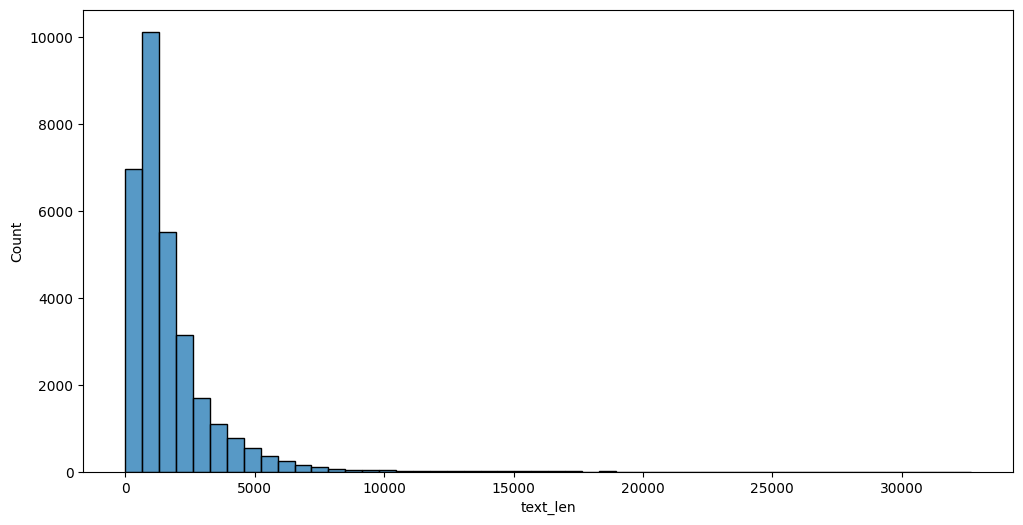

In [11]:
plt.figure(figsize=(12, 6))
sns.histplot(raw_dataset_df['text_len'], bins=50)

In [12]:
print(raw_dataset_df.shape)
raw_dataset_df = raw_dataset_df[raw_dataset_df["text_len"] <= 10_000]
print(raw_dataset_df.shape)

(31030, 4)
(30906, 4)


In [13]:
print(raw_dataset_df.shape)
raw_dataset_df.drop_duplicates(["text"], inplace=True)
print(raw_dataset_df.shape)

(30906, 4)
(29700, 4)


In [14]:
raw_dataset_df['datetime_stamp'] = raw_dataset_df['date'].apply(lambda v: datetime.strptime(v, "%Y-%m-%d %H:%M:%S"))
raw_dataset_df['datetime_stamp'] = raw_dataset_df['datetime_stamp'].apply(lambda v: v.replace(hour=0, minute=0, second=0))

In [15]:
raw_dataset_df.head(2)

,text,source,date,text_len,datetime_stamp
16261,واس جدة تلقى خادم الحرمين الشريفين الملك سلمان...,sabq,2015-08-01 07:51:33,920,2015-08-01
28287,لفت وزير العدل أشرف ريفي في تصريح امس انه لولا...,almadina,2015-08-10 19:24:39,1880,2015-08-10


In [16]:
from sentence_transformers import SentenceTransformer

model_id = 'sentence-transformers/LaBSE'

embedding_model = SentenceTransformer(model_id, device='cuda:0')

modules.json:   0%|          | 0.00/461 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.22k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/804 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/397 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/5.22M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.62M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

2_Dense/config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

In [17]:
news_embeddings = embedding_model.encode(raw_dataset_df['text'].values, show_progress_bar=True)

Batches:   0%|          | 0/929 [00:00<?, ?it/s]

In [18]:
news_embeddings.shape

(29700, 768)

# Dim Reduction

In [19]:
from umap import UMAP

umap_model = UMAP(n_neighbors=15, n_components=15,
                  min_dist=0.0, metric='cosine', random_state=42)

# Clustring

In [20]:
from hdbscan import HDBSCAN

hdbscan_model = HDBSCAN(min_cluster_size=50,
                        metric='euclidean',
                        cluster_selection_method='eom',
                        prediction_data=True)

# vectorizer

In [21]:
from sklearn.feature_extraction.text import CountVectorizer
import arabicstopwords.arabicstopwords as stp

stop_words = stp.stopwords_list()

vectorizer_model = CountVectorizer(min_df=3,
                                   stop_words=stop_words,
                                   analyzer='word',
                                   max_df=0.5,
                                   ngram_range=(1, 3)
                                   )

# Topic Representer

In [22]:
from bertopic.representation import KeyBERTInspired

keybert_model = KeyboardInterrupt()

representation_model = {
    "KeyBERT": keybert_model
}

# Let's Go

In [23]:
from bertopic import BERTopic

topic_model = BERTopic(
    embedding_model = embedding_model,
    umap_model = umap_model,
    hdbscan_model = hdbscan_model,
    vectorizer_model = vectorizer_model,
    representation_model = representation_model,
    top_n_words = 10,
    verbose = True)

topics, probs = topic_model.fit_transform(
    raw_dataset_df['text'].values,
    news_embeddings
)

2025-02-03 14:27:56,645 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-02-03 14:28:58,461 - BERTopic - Dimensionality - Completed ✓
2025-02-03 14:28:58,467 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-02-03 14:29:02,799 - BERTopic - Cluster - Completed ✓
2025-02-03 14:29:02,812 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-02-03 14:29:49,231 - BERTopic - Representation - Completed ✓


In [26]:
print(
    raw_dataset_df['text'].values[50],
    topics[50], probs[50]
)

topic_model.get_topic(17)

افتتح مدير عام الشؤون الصحية بمنطقة تبوك الصيدلي محمد الطويلعي وحدتي العناية المركزة والعزل بمستشفى الملك فهد بتبوك إضافة لعيادتي الأمراض التنفسية وفحص النساء وأوضح مدير مستشفى الملك فهد بتبوك سليمان علي أبوذراع أنه تم إنشاء وحدة عناية مركزة جديدة مجهزة بأحدث المواصفات بجانب تدعيمها الكامل بما يلزم من كوادر طبية وفنية لتسهم مع مستشفيات المنطقة في تقديم أفضل الخدمات الصحية مشيرا إلى أنه تم استحداث وحدة عزل داخل قسم الطوارئ خاصة بمرضى متلازمة الشرق الأوسط التنفسية كورونا مجهزة بجميع التجهيزات والفلاتر التي تضمن سلامة المريض والعاملين إضافة لاستحداث وحدة فحص خاصة بالنساء وتوسعة قاعة التدريب والتعليم بالمستشفى 61 1.0


[('داعش', 0.028457128864097708),
 ('المرصد', 0.024539143591377793),
 ('تنظيم داعش', 0.021678274700634853),
 ('المعارضة', 0.021399691429266458),
 ('السوري', 0.021188643767642755),
 ('الرمادي', 0.01975450630159828),
 ('قوات', 0.01952866260951705),
 ('الزبداني', 0.018597700808472943),
 ('الأنبار', 0.01796623272526497),
 ('قوات النظام', 0.01786942327159362)]

In [27]:
raw_dataset_df['topic'] = topics
raw_dataset_df['prob'] = probs

In [28]:
raw_dataset_df[raw_dataset_df['topic'] == 17].head(10)

,text,source,date,text_len,datetime_stamp,topic,prob
3508,أمطرت الفصائل المقاتلة المعارضة للنظام السوري ...,almadina,2015-07-22 09:50:53,469,2015-07-22,17,1.000000
20754,مع الإعلان عن تنفيذ قوات الأمن العراقية المرحل...,aawsat,2015-08-06 22:41:12,3902,2015-08-06,17,1.000000
2034,لقي ستة من مقاتلي المعارضة السورية على الأقل م...,alweeam,2015-07-21 17:02:20,1100,2015-07-21,17,1.000000
2141,طالبت جبهة النصرة التي تحتجز عدد من عناصر الجي...,alyaum,2015-07-21 02:46:03,2689,2015-07-21,17,0.815988
25678,قام عناصر تنظيم داعش بخطف نحو 230 مدنيا بينهم ...,alriyadh,2015-08-08 06:17:54,984,2015-08-08,17,0.797935
4372,على خلفية سيطرة تنظيم داعش على محافظات عراقية ...,alwatan,2015-07-22 00:58:11,2642,2015-07-22,17,0.607181
18001,نشر تنظيم جبهة النصرة ذراع تنظيم القاعدة في سو...,aljazirah,2015-08-03 21:08:19,2244,2015-08-03,17,0.801648
7317,أفاد المرصد السوري لحقوق الإنسان بأن طائرات ال...,aljazirah,2015-07-24 08:38:36,1707,2015-07-24,17,1.000000
11566,أعلن جهاز مكافحة الإرهاب في العراق أمس عن تحري...,aawsat,2015-07-27 17:14:49,3749,2015-07-27,17,1.000000
14094,هاجمت جبهة النصرة اليوم الجمعة مقرا للفرقة 30 ...,alriyadh,2015-07-31 18:20:00,1953,2015-07-31,17,0.809124


In [29]:
topics_per_class = topic_model.topics_per_class(
    raw_dataset_df['text'].values,
    classes = raw_dataset_df['source'].values,
)

14it [00:21,  1.56s/it]


In [31]:
topic_model.visualize_topics_per_class(topics_per_class, top_n_topics=20)

In [32]:
topics_over_time = topic_model.topics_over_time(
    raw_dataset_df['text'].values,
    raw_dataset_df['datetime_stamp'].values
)

18it [01:43,  5.75s/it]


In [33]:
topic_model.visualize_topics_over_time(
    topics_over_time,
    topics = [10,11,12,13,14,15,16,17,18,19]
)

# Topic filters

In [34]:
raw_dataset_df.head()

,text,source,date,text_len,datetime_stamp,topic,prob
16261,واس جدة تلقى خادم الحرمين الشريفين الملك سلمان...,sabq,2015-08-01 07:51:33,920,2015-08-01,-1,0.000000
28287,لفت وزير العدل أشرف ريفي في تصريح امس انه لولا...,almadina,2015-08-10 19:24:39,1880,2015-08-10,40,0.269353
21803,عقد مدير الكرة بالمنتخب السعودي زكي الصالح مسا...,alriyadh,2015-08-06 01:13:10,1197,2015-08-06,0,1.000000
28752,حوادث المعلمات ومعاناتهن في الوصول يوميا إلى م...,alwatan,2015-08-10 19:44:53,2701,2015-08-10,21,1.000000
2772,سبق جدة يقد الدكتور عبدالرحمن بن رجا الله السل...,sabq,2015-07-21 02:42:37,715,2015-07-21,58,1.000000


In [35]:
print(raw_dataset_df.shape)
filtered_raw_dataset_df = raw_dataset_df[ ~raw_dataset_df['topic'].isin([-1])]
print(filtered_raw_dataset_df.shape)

(29700, 7)
(19833, 7)


In [36]:
story = """
طرحت مؤسسة البترول الكويتية عطاءً؛ لبيع زيت وقود عالي الكبريت للتحميل في الفترة من فبراير/ شباط إلى إبريل/ نيسان.
وأوضحت مصادر تجارية، اليوم الخميس، أن المؤسسة تعرض شحنات من زيت الوقود عالي الكبريت تبلغ الواحدة 60 ألف طن لتحميلها من الكويت شهرياً بالفترة المذكورة.
"""

_topic, _prob =  topic_model.transform([story])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-02-03 14:35:30,389 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-02-03 14:35:46,286 - BERTopic - Dimensionality - Completed ✓
2025-02-03 14:35:46,287 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-02-03 14:35:46,289 - BERTopic - Cluster - Completed ✓


In [37]:
_topic, _prob

([11], array([0.96563826]))

In [38]:
topic_model.get_topic(_topic[0])

[('النفط', 0.062338908604355994),
 ('برميل', 0.03792932361024164),
 ('الخام', 0.0339751132798756),
 ('أسعار', 0.030311593463536842),
 ('للبرميل', 0.02767421738960898),
 ('مليون برميل', 0.022092282009242296),
 ('أسعار النفط', 0.02204587090815873),
 ('برميل يوميا', 0.021557144842525928),
 ('دولار للبرميل', 0.01969746162813079),
 ('برنت', 0.01931822502566932)]

In [39]:
filtered_raw_dataset_df[ filtered_raw_dataset_df['topic'] == _topic[0] ].head()

,text,source,date,text_len,datetime_stamp,topic,prob
19924,تعافى النفط إلى أعلى قليلا من 50 دولارا للبرمي...,alweeam,2015-08-04 18:13:36,1254,2015-08-04,11,1.000000
13010,عين اليوم سنغافورة تراجعت أسعار النفط في التعا...,3alyoum,2015-07-31 12:13:39,1686,2015-07-31,11,1.000000
29367,عين اليوم جدة تراجعت أسعار النفط اليوم الثلاثا...,3alyoum,2015-08-11 13:45:50,1117,2015-08-11,11,1.000000
15268,قالت إدارة معلومات الطاقة الأمريكية في بيانات ...,aleqtisadiya,2015-08-01 08:04:42,3788,2015-08-01,11,0.979497
20387,عين اليوم سنغافورة صعدت اسعار خام برنت فوق حاج...,3alyoum,2015-08-06 01:04:25,1931,2015-08-06,11,1.000000


# Save The Model

In [40]:
model_id = "sentence-transformers/LaBSE"

save_path = "/kaggle/working/safe_bertopic"

topic_model.save(save_path, serialization='safetensors',
                 save_ctfidf=True, save_embedding_model=model_id)

print(f"Model saved to {save_path}")

Model saved to /kaggle/working/safe_bertopic


# Load Model

In [41]:
loaded_model = BERTopic.load('/kaggle/working/safe_bertopic')